# CoOp MobileCLIP2

Classification and retrieval with text and or visual prompts.

Markdown WIP

In [1]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
!pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

If you need packages, uncomment the pip lines above and run this cell.


For debug:

In [2]:
#import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"         # make errors point to the right op
#os.environ["TORCH_SHOW_CPP_STACKTRACES"] = "1"

In [3]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import transforms

import torchinfo

import datasets

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device is {device}")

Device is cpu


### Config

In [ ]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class Config:
    #model_name: str = "ViT-B-32"
    #pretrained: str = "laion2b_s34b_b79k"
    # "MobileCLIP2-S0", "MobileCLIP2-S2", "MobileCLIP2-B", "MobileCLIP2-S3", "MobileCLIP2-S4", "MobileCLIP2-L-14"
    model_name = "MobileCLIP2-S0"
    pretrained = "dfndr2b"

    # "Donghyun99/Oxford-Flower-102", "jonathan-roberts1/EuroSAT", "tanganke/dtd", "flwrlabs/caltech101", "tanganke/sun397"
    cls_dataset = "tanganke/sun397"
    # "AnyModal/flickr30k"
    ret_dataset = "AnyModal/flickr30k"

    coop_text_prompt_save_path = 's0_coop_flower102_1.pt'
    coop_vis_prompt_save_path = 's0_coop_vis_flower102.pt'

    coop_version = "v0.1.1" # Prompt version for backwards compatibility

    k_per_class: int = 1 # (0 for 0shot, "all" for full dataset)

    #image_size: int = 224
    train_batch_size: int = 16
    val_batch_size: int = 16
    max_epochs: int = 100

    # Unfreeze (light finetune on top of prompt) (these constitute the "base")
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # LR split: prompts vs unfrozen base
    lr_text_prompt: float = 3e-4
    lr_vis_prompt: float = 3e-4
    lr_base: float = 1e-5
    # weight_decay
    wd_text_prompt: float = 0.0
    wd_vis_prompt: float = 0.1
    wd_base: float = 0.05

    multitask_loss_lambda: int = 0.3 # (1-lambda)*L_ret + lambda*L_cls

    text_prompt_len: int = 16
    vis_prompt_border_size: int = 32

    log_train_interval: int = 25
    log_val_interval: int = 100

    hook_attn_weights: bool = False

    # Overfit sanity tiny subset
    #overfit_n_classes: int = 2
    #overfit_k_per_class: int = 8
    #overfit_epochs: int = 50

cfg = Config()
cfg


Config(k_per_class=1, train_batch_size=16, val_batch_size=16, max_epochs=100, unfreeze_layers=(), lr_text_prompt=0.0003, lr_vis_prompt=0.0003, lr_base=1e-05, wd_text_prompt=0.0, wd_vis_prompt=0.1, wd_base=0.05, multitask_loss_lambda=0.3, text_prompt_len=16, vis_prompt_border_size=32, log_train_interval=25, log_val_interval=100, hook_attn_weights=False)

Load base model

In [5]:
# --- Load model + preprocess ---
clip_model, train_preprocess, preprocess = open_clip.create_model_and_transforms(cfg.model_name, pretrained=cfg.pretrained)
tokenizer = open_clip.get_tokenizer(cfg.model_name)
#torchinfo.summary(clip_model)

### Enable attention weights visualization

In [6]:
attn_maps = {}   # {layer_name: attn tensor [B, heads, N, N]}
attn_meta = {}   # {layer_name: {"H": H, "W": W}}

def make_fastvit_attn_hook(layer_name):
    def hook(module, inputs, output):
        """
        module: the Attention instance
        inputs[0]: x, shape (B, C, H, W)
        """
        x = inputs[0]
        B, C, H, W = x.shape
        N = H * W

        # Flatten to tokens as in Attention.forward
        x_flat = x.flatten(2).transpose(1, 2)     # (B, N, C)

        # qkv projection
        qkv = module.qkv(x_flat)                 # (B, N, 3*C)
        qkv = qkv.reshape(B, N, 3, module.num_heads, module.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)        # (3, B, heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]        # (B, heads, N, head_dim)

        # scaled dot-product attention (explicit, independent of fused_attn)
        q = q * module.scale                    # same as in original code
        attn = q @ k.transpose(-2, -1)         # (B, heads, N, N)
        attn = attn.softmax(dim=-1)
        # Optional: include dropout for parity
        attn = module.attn_drop(attn)

        # Store detached for visualization
        attn_maps[layer_name] = attn.detach().cpu()
        attn_meta[layer_name] = {"H": H, "W": W}
    return hook

In [7]:
if cfg.hook_attn_weights:
    for name, m in clip_model.visual.named_modules():
        # Be a bit defensive: check by name + attributes instead of type
        if m.__class__.__name__ == "Attention" and hasattr(m, "qkv"):
            #print(name, m)
            m.register_forward_hook(make_fastvit_attn_hook(name))
            print("Hooked:", name)

## Load datasets

### Load classification dataset (flower102)

In [8]:
from datasets import DatasetDict

cls_full_ds = datasets.load_dataset(
    cfg.cls_dataset,
    cache_dir="./hf_data",
)
#cls_full_train_ds = cls_full_ds["train"]
#cls_splits = cls_full_train_ds.train_test_split(test_size=0.1)
#cls_full_ds = DatasetDict({
#   "train": cls_splits["train"],
#   "validation": cls_splits["test"]
#})
cls_train_ds = cls_full_ds["train"]
cls_val_ds = cls_full_ds["train"]
#test_ds = full_ds["test"]

def transform(batch):
    imgs = [img.convert("RGB") for img in batch["image"]]
    batch["pixel_values"] = [preprocess(img) for img in imgs]
    return batch

cls_train_ds = cls_train_ds.with_transform(transform)
cls_val_ds   = cls_val_ds.with_transform(transform)
#test_ds = test_ds.with_transform(transform)

def cls_collate_fn(batch):
    images = torch.stack([b["pixel_values"] for b in batch])  # [B,3,H,W]
    labels = torch.tensor([b["label"] for b in batch])       # [B]
    return images, labels

cls_full_train_loader = DataLoader(cls_train_ds, batch_size=cfg.train_batch_size, shuffle=True, collate_fn=cls_collate_fn)
cls_val_loader = DataLoader(cls_val_ds, batch_size=cfg.val_batch_size, shuffle=False, collate_fn=cls_collate_fn)
#train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)
cls_train_loader_overfit = DataLoader(cls_train_ds.select(range(1)), batch_size=cfg.train_batch_size, shuffle=False, collate_fn=cls_collate_fn)

cls_label_feature = cls_train_ds.features["label"]
classnames = cls_label_feature.names
num_classes = cls_label_feature.num_classes

print(classnames)
print(f"Number of classes: {len(classnames)}")
print(f"Number or training samples: {len(cls_full_train_loader.dataset)}")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-95813d8dab877f(…):   0%|          | 0.00/43.4M [00:00<?, ?B/s]

data/validation-00000-of-00001-a2ccf8138(…):   0%|          | 0.00/43.1M [00:00<?, ?B/s]

data/test-00000-of-00001-1cc6f065cd5391e(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1020 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1020 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6149 [00:00<?, ? examples/s]

[' pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'c

In [9]:
from collections import defaultdict

def get_fewshot_dataloader(dl, k, *, label_col="label", seed=42):
    ds = dl.dataset
    #orig_tf = getattr(ds, "_transform", None)          # remember HF transform (if any)
    #base = ds.with_transform(None)                     # disable during index selection
    #print(ds)

    # collect indices per class (HF: fast column access)
    idx_by_label = defaultdict(list)
    for i, batch in enumerate(ds):
        y = batch[label_col]
        idx_by_label[y].append(i)

    # choose up to k per class, then shuffle globally
    rng = random.Random(seed)
    selected = []
    for idxs in idx_by_label.values():
        rng.shuffle(idxs)
        selected.extend(idxs[:k])
    rng.shuffle(selected)

    subset = ds.select(selected)
    #if orig_tf is not None:
    #    subset = subset.with_transform(orig_tf)

    # rebuild a DataLoader reusing the original settings
    return DataLoader(
        subset,
        batch_size=dl.batch_size or 1,
        shuffle=False,                 # we already shuffled indices
        collate_fn=dl.collate_fn,
        num_workers=dl.num_workers,
        pin_memory=getattr(dl, "pin_memory", False),
        drop_last=getattr(dl, "drop_last", False),
        persistent_workers=getattr(dl, "persistent_workers", False),
    )

In [10]:
if cfg.k_per_class == 0:
    # zeroshot # Todo: IMPLEMENT ME
    pass
elif cfg.k_per_class == "all":
    cls_train_loader = cls_full_train_loader
else:
    cls_train_loader = get_fewshot_dataloader(cls_full_train_loader, cfg.k_per_class)

print(f"Number of batches: {len(cls_train_loader)}, number of images: {len(cls_train_loader.dataset)}")

Number of batches: 7, number of images: 102


Dataloader with: 102 samples, 7 batches (16bs)


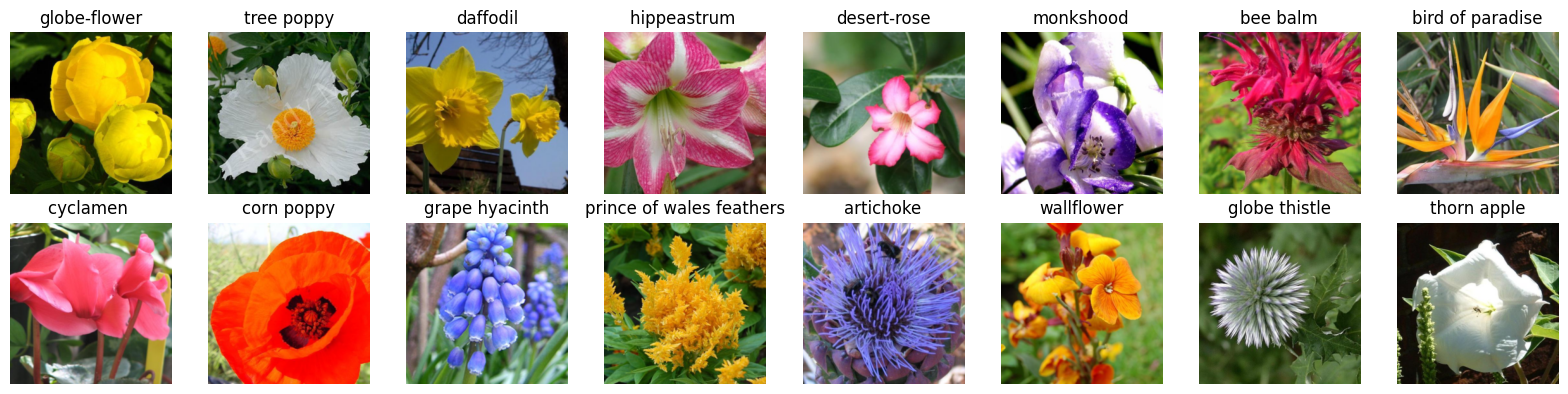

In [11]:
def preview_cls_dl(dl: DataLoader, classnames, rows: int=2, cols: int=8):
    print(f"Dataloader with: {len(dl.dataset)} samples, {len(dl)} batches ({dl.batch_size}bs)")
    batch = next(iter(dl))
    images, labels = batch
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].cpu().numpy().transpose(1, 2, 0)
            title = classnames[int(labels[idx])]
            axs[i, j].imshow(img)
            axs[i, j].set_title(title)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

preview_cls_dl(cls_train_loader, classnames)

In [12]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.4)  # larger fonts for print

In [13]:
cls_train_df = cls_train_loader.dataset.to_pandas()["label"].reset_index()
df = cls_train_df

In [14]:
!apt-get update -y
!apt-get install -y ttf-mscorefonts-installer fontconfig
!fc-cache -f -v

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'fc-cache' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
import seaborn as sns

compact = True
sns.set_theme(context="paper")
mpl.rcParams["font.family"] = "Times New Roman"
g = sns.displot(
    df["label"].value_counts(), bins=30,
    height=2 if compact else 4, aspect=1.2
)
g.refline(x=8, linestyle=":", linewidth=1, color="red")  # dotted threshold at 8 images/class
g.set_axis_labels("Samples per label", "Number of labels")

NameError: name 'mpl' is not defined

### Load retrieval dataset (flickr30k)

In [ ]:
from datasets import DatasetDict

ret_full_ds = datasets.load_dataset(
    cfg.ret_dataset,
    cache_dir="./hf_data",
)

print(ret_full_ds)

ret_train_ds = ret_full_ds["train"]
ret_val_ds = ret_full_ds["validation"]
#test_ds = full_ds["test"]

def transform(batch):
    imgs = [img.convert("RGB") for img in batch["image"]]
    batch["pixel_values"] = [preprocess(img) for img in imgs]
    return batch

ret_train_ds = ret_train_ds.with_transform(transform)
ret_val_ds   = ret_val_ds.with_transform(transform)
#test_ds = test_ds.with_transform(transform)

def ret_collate_fn(batch):
    images = torch.stack([b["pixel_values"] for b in batch])  # [B,3,H,W]
    descriptions = [b["alt_text"][0] for b in batch]
    description_ids = tokenizer(descriptions)
    #image_features = clip_model.encode_image(images)
    #image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    return {
        "pixel_values": images,
        #"image_features": image_features, # Can be precomputed as the image tower is frozen
        "description": descriptions,
        "description_ids": description_ids,
    }

ret_train_loader = DataLoader(ret_train_ds, batch_size=cfg.train_batch_size, shuffle=True, collate_fn=ret_collate_fn)
ret_val_loader = DataLoader(ret_val_ds, batch_size=cfg.val_batch_size, shuffle=False, collate_fn=ret_collate_fn)
#train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
print(len(ret_val_loader))
print(len(ret_val_loader.dataset))

In [ ]:
def preview_ret_dl(dl: DataLoader, rows: int=2, cols: int=8):
    print(f"Dataloader with: {len(dl.dataset)} samples, {len(dl)} batches ({dl.batch_size}bs)")
    batch = next(iter(dl))
    images, descriptions = batch["pixel_values"], batch["description"]
    fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            desc = descriptions[idx]
            if cols > 1:
                axs[i, j].imshow(img)
                axs[i, j].set_title(desc)
                axs[i, j].axis('off')
            else:
                axs[i].imshow(img)
                axs[i].set_title(desc)
                axs[i].axis('off')
    plt.tight_layout()
    plt.show()

preview_ret_dl(ret_train_loader, rows=4, cols=1)

## Prompt class definitions

### Hardcoded Prompt

- A prefix prompt, as a hardcoded string, which can be used similar to the trainable CoOpTextPrompt. Used for testing the zeroshot accuracy.

In [16]:
class HardcodedClsPrompt(nn.Module):
    def __init__(self, clip, classnames, prompt_prefix="A photo of a "):
        super().__init__()
        self.clip = clip
        self.text_tower = getattr(self.clip, "text", self.clip)
        self.prompt_prefix = prompt_prefix

        prompts = [prompt_prefix + c for c in classnames]
        #bs=128
        #for i in range(len(prompts)//bs):
        text_tokens = tokenizer(prompts).to(self.text_tower.token_embedding.weight.device)
        text_features = clip.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        self.register_buffer("text_features", text_features)

    def forward(self, text_ids=None):
        return self.text_features

In [17]:
class HardcodedRetPrompt(nn.Module):
    def __init__(self, clip):
        super().__init__()
        self.clip = clip

    def forward(self, text_ids=None):
        return self.clip.encode_text(text_ids)

### CoOp Text Prompt


- class implementation of the textual prompt, which can be used direclty by the CoOpClip class for both training and inference.

- When provided to the CoOpClip, it appends to the actual prompt used(be that a classname or the image description to be retrieved).

> n_ctx = the length of the prompt in words

In [18]:
class CoOpTextPrompt(nn.Module):
    def __init__(self, clip, tokenizer, n_ctx=16, coop_version=cfg.coop_version, init_scale=0.02):
        super().__init__()
        self.coop_version = coop_version

        self.clip = clip
        self.text_tower = getattr(self.clip, "text", self.clip)
        #self.visual_tower = getattr(self.model, "visual", self.model)
        self.tokenizer = tokenizer

        # Text transformer sizes
        self.context_length = getattr(self.text_tower, "context_length", 77)
        self.width = self.text_tower.token_embedding.weight.shape[1] # 512

        # Learnable context (n_ctx continuous "tokens")
        self.ctx = nn.Parameter(init_scale * torch.randn(n_ctx, self.width))

        # Freeze CLIP
        for p in self.text_tower.parameters():
            p.requires_grad = False
        for p in self.clip.parameters():
            p.requires_grad = False

    def n_ctx(self):
        return self.ctx.size(0)

    def train(self, mode=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.text_tower.train()
        else:
          self.clip.eval()
          self.text_tower.eval()

    def forward(self, text_ids, backwards_compat=True):
        eot_indices = text_ids.argmax(dim=-1)
        # text_ids: [B, L]
        B = text_ids.size(0)

        # Frozen lookup for class tokens
        with torch.no_grad():
            tok_emb = self.text_tower.token_embedding(text_ids)  # [B, L, W]

        sos = tok_emb[:, :1, :]         # [B,1,W]
        description_part = tok_emb[:, 1:, :]  # [B,L-1,W]

        # Learnable context repeated across classes
        ctx = self.ctx.unsqueeze(0).expand(B, -1, -1)  # [B, n_ctx, W]

        # [SOS] + [CTX...CTX] + [description tokens...]
        x = torch.cat([sos, ctx, description_part], dim=1)  # [B, 1+n_ctx+(L-1), W]

        # Pad/truncate to model context length
        L_target = getattr(self.text_tower, "context_length", 77)
        if x.size(1) > L_target:
            x = x[:, :L_target, :]
        elif x.size(1) < L_target:
            pad_len = L_target - x.size(1)
            pad = x.new_zeros(B, pad_len, x.size(2))
            x = torch.cat([x, pad], dim=1)
        L = x.size(1)

        # Dtypes, pos emb, and (optional) attn mask, all sliced to L
        text_dtype = self.text_tower.token_embedding.weight.dtype
        pos = self.text_tower.positional_embedding[:L].to(text_dtype)  # [L,W]

        attn = getattr(self.text_tower, "attn_mask", None)
        if attn is not None:
            attn = attn[:L, :L].to(text_dtype)  # ensure (L,L)

        # Respect transformer.batch_first
        batch_first = getattr(self.text_tower.transformer, "batch_first", False)
        if batch_first:
            # want [N, L, D]
            x = x.to(text_dtype) + pos.unsqueeze(0)   # [C,L,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # stays [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]
        else:
            # want [L, N, D]
            x = (x.to(text_dtype) + pos).permute(1, 0, 2)  # [L,C,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # [L,C,W]
            x = x.permute(1, 0, 2)                         # [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]

        if self.coop_version == "v0.1.0":
            n_ctx = ctx.shape[0]
        else:
            n_ctx = self.n_ctx()
        # Pool at EOT (shift by n_ctx), clamp in case of truncation
        eot_indices = (eot_indices + n_ctx).clamp(max=L-1)
        text_emb = x[torch.arange(B, device=eot_indices.device), eot_indices] @ self.text_tower.text_projection  # [C,D]

        # Normalize
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return text_emb

### CoOp Visual Prompt


- class implementation of the visual prompt, which can be used direclty by the CoOpClip class for both training and inference

- When provided to the CoOpClip, it adds a trainable border on top of the image.

> n_ctx = the length of the prompt in words

In [19]:
class CoOpVisPrompt(nn.Module):
    def __init__(self, clip, border_size=50, img_size=256, init_scale=0.02, coop_version=cfg.coop_version):
        super().__init__()
        self.coop_version = coop_version

        self.clip = clip
        #self.text_tower = getattr(self.clip, "text", self.clip)
        #self.visual_tower = getattr(self.model, "visual", self.model)

        #self.img_size = img_size
        #self.border_size = border_size

        mask = self.create_mask(img_size, border_size)
        self.register_buffer("mask", mask)

        self.ctx = nn.Parameter(init_scale * torch.randn(3, img_size, img_size) * self.mask)

        # Freeze clip
        for p in self.clip.parameters():
            p.requires_grad = False

    def img_size(self):
        return self.mask.shape[1]

    def border_size(self):
        row = self.mask[0][self.mask.shape[1] // 2]
        return int((row == 0).int().argmax(dim=0))

    def create_mask(self, img_size, border_size):
        mask = torch.zeros(3, img_size, img_size)
        mask[:, :border_size, :] = 1
        mask[:, -border_size:, :] = 1
        mask[:, :, :border_size] = 1
        mask[:, :, -border_size:] = 1
        return mask

    def train(self, mode=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          #self.ctx.train()
          #self.text_tower.train()
        else:
          self.clip.eval()
          #self.ctx.eval()
          #self.text_tower.eval()

    def forward(self, images):
          prompt = self.ctx * self.mask
          image_features = self.clip.encode_image(images + prompt) # Broadcast over B
          return image_features

### CoOpClip class

- The one which does the wiring between the clip and the two prompting methods(text/visual). The prompts can be used one at the time or combined.

In [20]:
class CoOpClip(nn.Module):
    def __init__(self, clip, coop_text_prompt=None, coop_vis_prompt=None):
        super().__init__()
        self.clip = clip
        self.coop_text_prompt = coop_text_prompt
        self.coop_vis_prompt = coop_vis_prompt

        self.clip.requires_grad_(False)

        # These should already be true
        #if self.coop_text_prompt is not None:
        #    self.coop_text_prompt.requires_grad_(True)
        #if self.coop_vis_prompt is not None:
        #    self.coop_vis_prompt.requires_grad_(True)

    def train(self, mode: bool=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          if self.coop_text_prompt is not None:
              self.coop_text_prompt.train()
          if self.coop_vis_prompt is not None:
              self.coop_vis_prompt.train()
        else:
          self.clip.eval()
          if self.coop_text_prompt is not None:
              self.coop_text_prompt.eval()
          if self.coop_vis_prompt is not None:
              self.coop_vis_prompt.eval()

    def forward_text(self, texts):
        if self.coop_text_prompt is not None:
            text_features = self.coop_text_prompt(texts)
        else:
            text_features = self.clip.encode_text(texts)
        #text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        return text_features

    def forward_image(self, images):
        if self.coop_vis_prompt is not None:
            image_features = self.coop_vis_prompt(images)
        else:
            image_features = self.clip.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features

    def forward(self, images, texts):
        image_features = self.forward_image(images)
        text_features = self.forward_text(texts)
        ## TODO: Use the actual model trained scale
        logits = 100.0 * image_features @ text_features.T
        return logits

In [21]:
def cls_accuracy(logits, labels): # Accuracy for classification
    preds = logits.argmax(dim=1) # Per image prediction
    correct = (preds == labels).float().mean().item()
    return correct

def ret_accuracy(logits): # Accuracy for retrieval (from text to image only!)!
    preds = logits.argmax(dim=0) # Per text prediction
    labels = torch.arange(0, logits.size(0), device=logits.device)
    correct = (preds == labels).float().mean().item()
    return correct

In [22]:
class SimetricalCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, logits):
        bs = logits.size(0)
        labels = torch.arange(bs, device=logits.device)
        loss_1 = self.criterion(logits, labels)
        loss_2 = self.criterion(logits.T, labels)
        return (loss_1 + loss_2) / 2.0

In [23]:
def make_cls_report(all_loss, y_true, y_pred):
    all_loss = all_loss.detach().cpu()
    y_true = y_true.detach().cpu()
    y_pred = y_pred.detach().cpu()
    report = {
          "loss": all_loss.mean().item(),
          "accuracy": accuracy_score(y_true, y_pred),
          "macro_f1_score": f1_score(y_true, y_pred, average="macro")
    }
    return report

def make_ret_report(all_loss, logits):
    #all_loss = torch.tensor(all_loss)
    all_loss = all_loss.detach().cpu()
    ret_text_to_image_acc = ret_accuracy(logits)
    #ret_image_to_text_acc = ret_i2t_accuracy(logits)
    report = {
          "loss": all_loss.mean().item(),
          "accuracy": ret_text_to_image_acc,
    }
    return report

In [24]:
from sklearn.metrics import f1_score, accuracy_score

@torch.no_grad()
def eval_cls(model, classnames, test_loader, loss_fn, device, desc="eval", pbar=True):
    model.eval()
    loss_sum, correct, count = 0.0, 0, 0
    iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
    #all_image_features = []
    class_token_ids = tokenizer(classnames).to(device)

    #print(class_token_ids)
    #return None, None

    all_loss = []
    all_true = []
    all_pred = []

    for images, labels in iterator:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model.forward(images, class_token_ids)

        loss = loss_fn(logits, labels)
        preds = logits.argmax(dim=1)

        all_loss.append(loss.item())
        all_true.append(labels.detach().cpu())
        all_pred.append(preds.detach().cpu())

        bs = labels.size(0)
        loss_sum += loss.item()
        correct += (preds == labels).sum().item()
        count += bs

        if pbar:
          acc = (correct / max(1, count)) * 100.0
          iterator.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

    all_loss = torch.tensor(all_loss)
    all_true = torch.cat(all_true)
    all_pred = torch.cat(all_pred)

    report = make_cls_report(all_loss, all_true, all_pred)

    #report = classification_report(all_true, all_pred, output_dict=True)
    #report["avg_loss"] = avg_loss

    return report

@torch.no_grad()
def eval_ret(model, test_loader, loss_fn, device, desc="eval", pbar=True):
    model.eval()
    loss_sum, correct, count = 0.0, 0, 0
    iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
    all_image_features = []
    all_text_features = []
    for batch in iterator:
        images, description_ids = batch["pixel_values"], batch["description_ids"]
        images = images.to(device, non_blocking=True)
        description_ids = description_ids.to(device, non_blocking=True)

        image_features = model.forward_image(images)
        text_features = model.forward_text(description_ids)

        all_image_features.append(image_features)
        all_text_features.append(text_features)

    # For the true accuracy, it is needed to retrieve the text from all the images
    all_image_features = torch.cat(all_image_features, dim=0)
    all_text_features = torch.cat(all_text_features, dim=0)

    logits = all_image_features @ all_text_features.T

    loss = loss_fn(logits)
    acc = ret_accuracy(logits)

    report = make_ret_report(loss, logits)

    return report

In [25]:
def make_optimizer_params(model, cfg):
    params = []
    if model.coop_text_prompt is not None and model.coop_text_prompt.ctx is not None:
        params.append({
            "params": model.coop_text_prompt.ctx,
            "lr": cfg.lr_text_prompt,
            "weight_decay": cfg.wd_text_prompt,
        })
    if model.coop_vis_prompt is not None and model.coop_vis_prompt.ctx is not None:
        params.append({
            "params": model.coop_vis_prompt.ctx,
            "lr": cfg.lr_vis_prompt,
            "weight_decay": cfg.wd_vis_prompt,
        })
    base_params = [p for p in model.clip.parameters() if p.requires_grad]
    if len(base_params) > 0:
        params.append({
            "params": base_params,
            "lr": cfg.lr_base,
            "weight_decay": cfg.wd_base,
        })
    return params

## Training loop definitions

### There follows 3 training loops, classification, retrieval and multitask(both).

The contain history logging train and val accuracy and loss.

Important params from the config:

- max_epochs (Early stopping not implemented)
- lr_text_prompt
- lr_vis_prompt
- lr_base
- log_train_interval
> Number of steps (batch forwards) neccesary for each train log
- log_val_interval
> Number of steps neccesary for each training (**Note:** that the validation is being done on the full validation split, so it might take a lot of time on some datasets. val_loader can be manually adjusted before to address this issue).

### Train classifier

In [26]:
def train_cls(
    model, classnames, train_loader, val_loader, config, device="cpu"
):
    model.to(device)
    class_token_ids = tokenizer(classnames).to(device)

    epochs = config.max_epochs
    #batch_size = config.batch_size
    log_train_interval = config.log_train_interval
    log_val_interval = config.log_val_interval

    params = make_optimizer_params(model, config)
    optimizer = torch.optim.AdamW(params)
    loss_fn = nn.CrossEntropyLoss()

    t = 0 # current_time_step
    # Todo add batches per epoch

    history = {
        "train": {
            "time": [], "report": [],
        },
        "val": {
            "time": [], "report": [],
        }
    }

    model.eval()
    with torch.no_grad():
        val_report = eval_cls(
            model, classnames, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=True
        )
        history['val']['time'].append(t)
        history['val']['report'].append(val_report)

        tqdm.write(
            f"Before training: "
            f"val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f}%  val_f1_score={val_report["macro_f1_score"]}"
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, (images, labels) in enumerate(iterator, start=1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images, class_token_ids)
            loss = loss_fn(logits, labels)

            train_report = make_cls_report(loss, labels, logits.argmax(dim=-1))

            history["train"]['time'].append(t)
            history["train"]["report"].append(train_report)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                    f"""loss={train_report["loss"]:.4f}  acc={train_report["accuracy"]*100:.2f}  f1={train_report["macro_f1_score"]} \n"
                    val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f} val_f1={val_report["macro_f1_score"]} %"""
                )

            if log_val_interval and t % log_val_interval == 0:
                val_report = eval_cls(
                     model, classnames, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
                )
                history["val"]['time'].append(t)
                history["val"]['report'].append(val_report)
                iterator.set_postfix_str(
                    f"""loss={train_report["loss"]:.4f}  acc={train_report["accuracy"]*100:.2f}  macro_f1={train_report["macro_f1_score"]} \n"
                    val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f} val_macro_f1={val_report["macro_f1_score"]} %"""
                )
        last_train_reports = history["train"]['report'][-min(len(train_loader),100):]
        avg_train_loss = np.mean([report["loss"] for report in last_train_reports])
        avg_train_acc = np.mean([report["accuracy"] for report in last_train_reports])

        if log_val_interval:
            avg_val_loss = history["val"]['report'][-1]["loss"]
            avg_val_acc = history["val"]["report"][-1]["accuracy"]
            tqdm.write(
                f"Epoch {epoch:03d}: "
                f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
                f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
            )
        else:
            tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
        )

    if log_val_interval and t > 0:
        val_report = eval_cls(
              model, classnames, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
        )
        history["val"]['time'].append(t)
        history["val"]['report'].append(val_report)
    return history

### Train retrieval

In [27]:
def train_ret(
    model, train_loader, val_loader, config, device="cpu",
):
    model.to(device)

    epochs = config.max_epochs
    #batch_size = config.batch_size
    log_train_interval = config.log_train_interval
    log_val_interval = config.log_val_interval

    params = make_optimizer_params(model, config)
    optimizer = torch.optim.AdamW(params)
    loss_fn = SimetricalCrossEntropyLoss()

    t = 0 # current_time_step

    history = {
        "train": {
            "time": [], "report": [],
        },
        "val": {
            "time": [], "report": [],
        }
    }

    model.eval()
    with torch.no_grad():
        val_report = eval_ret(
            model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=True
        )
        history["val"]["time"].append(t)
        history["val"]["report"].append(val_report)

        tqdm.write(
            f"Before training: "
            f"val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f}%"
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, batch in enumerate(iterator, start=1):
            images, description_ids = batch["pixel_values"], batch["description_ids"]
            images = images.to(device, non_blocking=True)
            description_ids = description_ids.to(device, non_blocking=True)

            logits = model(images, description_ids)
            loss = loss_fn(logits)

            train_report = make_ret_report(loss, logits)

            history["train"]["time"].append(t)
            history["train"]["report"].append(train_report)

            #history['train_time'].append(t)
            #history['train_loss'].append(loss.item())
            #history['train_acc'].append(acc)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                    f"""loss={train_report["loss"]:.4f}  acc={train_report["accuracy"]*100:.2f}%\n"
                    val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f}%"""
                )

            if log_val_interval and t % log_val_interval == 0:
                val_report = eval_ret(
                     model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
                )
                history["val"]['time'].append(t)
                history["val"]['report'].append(val_report)
                iterator.set_postfix_str(
                    f"""loss={train_report["loss"]:.4f}  acc={train_report["accuracy"]*100:.2f}%\n"
                    val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f}%"""
                )

        last_train_reports = history["train"]['report'][-min(len(train_loader),100):]
        avg_train_loss = np.mean([report["loss"] for report in last_train_reports])
        avg_train_acc = np.mean([report["accuracy"] for report in last_train_reports])
        avg_val_loss = history["val"]['report'][-1]["loss"]
        avg_val_acc = history["val"]["report"][-1]["accuracy"]


        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    if t > 0:
        val_report = eval_ret(
              model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
        )
        history["val"]['time'].append(t)
        history["val"]['report'].append(val_report)

    return history

### Train multitask (cls + ret)

Not well tested.

The loss for the multitask is similar to a distil loss.

`L_total = (1-lambda)*L_ret + lambda*L_cls`


During the main loop, the loop over the retrieval dataset, we also evaluate the classification loss by getting the next batch from the infinte loader.
This feels like a hack, using something like zip might be cleaner.

After testing some more and find this stable, consider having multiple cls datasets at the same time (the loss being the mean of the sublosses)

In [28]:
from copy import deepcopy

def infinite_loader(dataloader):
    while True:
        for batch in dataloader:
            yield batch

def train_multitask(
    model, ret_train_loader, ret_val_loader, classnames,
    cls_train_loader, cls_val_loader, config, device="cpu",
):
    model.to(device)
    class_token_ids = tokenizer(classnames).to(device)

    epochs = config.max_epochs
    #batch_size = config.batch_size
    log_train_interval = config.log_train_interval
    log_val_interval = config.log_val_interval
    loss_lambda = config.multitask_loss_lambda

    inf_cls_train_loader = infinite_loader(cls_train_loader)
    #inf_cls_val_loader = infinite_loader(cls_val_loader)

    params = make_optimizer_params(model, config)
    optimizer = torch.optim.AdamW(params)
    ret_loss_fn = SimetricalCrossEntropyLoss()
    cls_loss_fn = nn.CrossEntropyLoss()

    t = 0 # current_time_step
    # Todo add batches per epoch

    per_task_empty_history = {
        "train": {"time": [], "report": []},
        "val": {"time": [], "report": []},
    }

    history = {
        "ret": deepcopy(per_task_empty_history),
        "cls": deepcopy(per_task_empty_history),
    }

    model.eval()
    with torch.no_grad():
        task = "ret"
        ret_val_report = eval_ret(
            model, ret_val_loader, loss_fn=ret_loss_fn, device=device, desc="valid", pbar=True
        )
        history[task]["val"]["time"].append(t)
        history[task]["val"]["report"].append(ret_val_report)

        task = "cls"
        cls_val_report = eval_cls(
            model, classnames, cls_val_loader, loss_fn=cls_loss_fn, device=device, desc="valid", pbar=True
        )
        history[task]["val"]["time"].append(t)
        history[task]["val"]["report"].append(cls_val_report)


        tqdm.write(
            f"Before training: "
            f"""ret_val_loss={ret_val_report["loss"]:.4f}  ret_val_acc={ret_val_report["accuracy"]*100:.2f}%\n
                cls_val_loss={cls_val_report["loss"]:.4f}  cls_val_acc={cls_val_report["accuracy"]*100:.2f}%"""
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            ret_train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, batch in enumerate(iterator, start=1):
            images, description_ids = batch["pixel_values"], batch["description_ids"]
            images = images.to(device, non_blocking=True)
            description_ids = description_ids.to(device, non_blocking=True)

            logits = model(images, description_ids)
            ret_loss = ret_loss_fn(logits)
            #ret_acc = ret_accuracy(logits)

            task = "ret"
            ret_train_report = make_ret_report(ret_loss, logits)
            history[task]["train"]["time"].append(t)
            history[task]["train"]["report"].append(ret_train_report)

            images, labels = next(inf_cls_train_loader)
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images, class_token_ids)
            cls_loss = cls_loss_fn(logits, labels)

            task = "cls"
            cls_train_report = make_cls_report(cls_loss, labels, logits.argmax(-1))
            history[task]["train"]["time"].append(t)
            history[task]["train"]["report"].append(cls_train_report)

            loss = (1 - loss_lambda) * ret_loss + loss_lambda * cls_loss

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                f"""ret_val_loss={ret_val_report["loss"]:.4f}  ret_val_acc={ret_val_report["accuracy"]*100:.2f}%\n
                cls_val_loss={cls_val_report["loss"]:.4f}  cls_val_acc={cls_val_report["accuracy"]*100:.2f}%"""
                )

            if log_val_interval and t % log_val_interval == 0:
                ret_val_report = eval_ret(
                     model, ret_val_loader, loss_fn=ret_loss_fn, device=device, desc="valid", pbar=False
                )
                task = "ret"
                history[task]["val"]["time"].append(t)
                history[task]["val"]["report"].append(ret_val_report)

                cls_val_report = eval_cls(
                     model, classnames, cls_val_loader, loss_fn=cls_loss_fn, device=device, desc="valid", pbar=False
                )
                task = "cls"
                history[task]["val"]["time"].append(t)
                history[task]["val"]["report"].append(cls_val_report)
                iterator.set_postfix_str(
                    f"""ret_val_loss={ret_val_report["loss"]:.4f}  ret_val_acc={ret_val_report["accuracy"]*100:.2f}%\n
                    cls_val_loss={cls_val_report["loss"]:.4f}  cls_val_acc={cls_val_report["accuracy"]*100:.2f}%"""
                )

        task = "ret"
        last_train_reports = history[task]["train"]['report'][-min(len(ret_train_loader),100):]
        avg_train_loss = np.mean([report["loss"] for report in last_train_reports])
        avg_train_acc = np.mean([report["accuracy"] for report in last_train_reports])
        avg_val_loss = history[task]["val"]['report'][-1]["loss"]
        avg_val_acc = history[task]["val"]["report"][-1]["accuracy"]

        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    return history

In [29]:
def plot_metric(ax, history, metric):
    train_metric_list = [report[metric] for report in history["train"]["report"]]
    assert len(history["train"]["time"]) == len(train_metric_list)

    ax.plot(history["train"]["time"], train_metric_list, label='train', linewidth=1.5)

    if 'val' in history and len(history["val"]) and len(history["val"]["report"]) and metric in history["val"]["report"][0]:
        val_metric_list = [report[metric] for report in history["val"]["report"]]
        ax.plot(history["val"]["time"], val_metric_list, label='val', linewidth=1.2, marker='o', markersize=3)

    ax.set_xlabel('Time'); ax.set_ylabel(metric.capitalize()); ax.set_title(metric.capitalize()); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    plot_metric(axes[0], history, "loss")
    plot_metric(axes[1], history, "accuracy")

    plt.show()

## Zero shot

In [30]:
hardcoded_text_prompt = HardcodedClsPrompt(
    clip=clip_model,
    classnames=classnames,
    prompt_prefix="A photo of a ",
)

zeroshotclip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=hardcoded_text_prompt,
).to(device)

In [31]:
eval_cls(
    model=zeroshotclip_model,
    classnames=classnames,
    test_loader=cls_val_loader,
    loss_fn=nn.CrossEntropyLoss(),
    device=device
)

eval:   0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# hardcoded_text_prompt = HardcodedRetPrompt(
#     clip=clip_model,
# )

# zeroshotclip_model = CoOpClip(
#     clip=clip_model,
#     coop_text_prompt=hardcoded_text_prompt,
# ).to(device)

In [ ]:
# eval_ret(
#     model=zeroshotclip_model,
#     test_loader=ret_val_loader,
#     loss_fn=SimetricalCrossEntropyLoss(),
#     device=device
# )

## Create the actual prompts and the composed model.

- Create new context optimizable prompts (initialized with random values)
- Test before training (should be worse than the zeroshot in general)
- Train for cls/ret/both
- Test again

In [32]:
coop_text_prompt = CoOpTextPrompt(
    clip=clip_model,
    tokenizer=tokenizer,
    n_ctx=cfg.text_prompt_len,
)

#coop_text_prompt = load_coop_prompt(clip_model, tokenizer, "s0_coop_flower102_all.pt")
#coop_text_prompt.ctx.requires_grad = False

coop_vis_prompt = CoOpVisPrompt(
    clip=clip_model,
    init_scale=0.02,
    border_size=cfg.vis_prompt_border_size,
)

coopclip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=coop_text_prompt,
    coop_vis_prompt=None,
).to(device)

In [ ]:
eval_cls(
    model=coopclip_model,
    classnames=classnames,
    test_loader=cls_val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
)

In [ ]:
eval_ret(
    model=coopclip_model,
    test_loader=ret_val_loader,
    device=device,
    loss_fn=SimetricalCrossEntropyLoss(),
)

In [ ]:
#cfg.log_val_interval = len(cls_train_loader) * cfg.max_epochs // 5
#cfg.log_val_interval

In [ ]:
#cfg.lr_vis_prompt = 3e-4

### Train classification

In [33]:
#cfg.log_val_interval = 100

#cfg.max_epochs = 30
#cfg.lr_vis_prompt = 3e-4
#cfg.log_val_interval = 100
#cfg.max_epochs = 30

history = train_cls(
    coopclip_model,
    classnames=classnames,
    train_loader=cls_train_loader,
    val_loader=cls_val_loader,
    config=cfg,
    device=device,
)

valid:   0%|          | 0/64 [00:00<?, ?it/s]

Before training: val_loss=2.6245  val_acc=49.31%  val_f1_score=0.41356142696795417


Epoch 1/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 001: train_loss=1.7730  train_acc=63.69%  val_loss=2.6245  val_acc=49.31%


Epoch 2/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 002: train_loss=1.1694  train_acc=72.62%  val_loss=2.6245  val_acc=49.31%


Epoch 3/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 003: train_loss=1.0683  train_acc=74.40%  val_loss=2.6245  val_acc=49.31%


Epoch 4/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 004: train_loss=0.9951  train_acc=75.30%  val_loss=2.6245  val_acc=49.31%


Epoch 5/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 005: train_loss=0.9302  train_acc=75.30%  val_loss=2.6245  val_acc=49.31%


Epoch 6/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 006: train_loss=0.8731  train_acc=77.68%  val_loss=2.6245  val_acc=49.31%


Epoch 7/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 007: train_loss=0.8255  train_acc=80.36%  val_loss=2.6245  val_acc=49.31%


Epoch 8/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 008: train_loss=0.7699  train_acc=81.25%  val_loss=2.6245  val_acc=49.31%


Epoch 9/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 009: train_loss=0.7227  train_acc=82.14%  val_loss=2.6245  val_acc=49.31%


Epoch 10/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 010: train_loss=0.6635  train_acc=83.04%  val_loss=2.6245  val_acc=49.31%


Epoch 11/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 011: train_loss=0.6112  train_acc=84.82%  val_loss=2.6245  val_acc=49.31%


Epoch 12/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 012: train_loss=0.5500  train_acc=87.50%  val_loss=2.6245  val_acc=49.31%


Epoch 13/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 013: train_loss=0.4906  train_acc=87.50%  val_loss=2.6245  val_acc=49.31%


Epoch 14/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 014: train_loss=0.4495  train_acc=90.18%  val_loss=2.6245  val_acc=49.31%


Epoch 15/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 015: train_loss=0.3802  train_acc=93.75%  val_loss=0.6991  val_acc=80.98%


Epoch 16/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 016: train_loss=0.3310  train_acc=92.86%  val_loss=0.6991  val_acc=80.98%


Epoch 17/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 017: train_loss=0.2829  train_acc=96.43%  val_loss=0.6991  val_acc=80.98%


Epoch 18/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 018: train_loss=0.2413  train_acc=99.11%  val_loss=0.6991  val_acc=80.98%


Epoch 19/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 019: train_loss=0.2091  train_acc=99.11%  val_loss=0.6991  val_acc=80.98%


Epoch 20/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 020: train_loss=0.1789  train_acc=99.11%  val_loss=0.6991  val_acc=80.98%


Epoch 21/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 021: train_loss=0.1626  train_acc=99.11%  val_loss=0.6991  val_acc=80.98%


Epoch 22/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 022: train_loss=0.1374  train_acc=99.11%  val_loss=0.6991  val_acc=80.98%


Epoch 23/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 023: train_loss=0.1227  train_acc=99.11%  val_loss=0.6991  val_acc=80.98%


Epoch 24/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 024: train_loss=0.0991  train_acc=100.00%  val_loss=0.6991  val_acc=80.98%


Epoch 25/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 025: train_loss=0.0912  train_acc=100.00%  val_loss=0.6991  val_acc=80.98%


Epoch 26/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 026: train_loss=0.0746  train_acc=100.00%  val_loss=0.6991  val_acc=80.98%


Epoch 27/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 027: train_loss=0.0657  train_acc=100.00%  val_loss=0.6991  val_acc=80.98%


Epoch 28/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 028: train_loss=0.0571  train_acc=100.00%  val_loss=0.6991  val_acc=80.98%


Epoch 29/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 029: train_loss=0.0525  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 30/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 030: train_loss=0.0478  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 31/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 031: train_loss=0.0484  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 32/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 032: train_loss=0.0484  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 33/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 033: train_loss=0.0557  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 34/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 034: train_loss=0.0549  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 35/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 035: train_loss=0.0560  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 36/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 036: train_loss=0.0594  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 37/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 037: train_loss=0.0563  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 38/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 038: train_loss=0.0586  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 39/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 039: train_loss=0.1140  train_acc=97.32%  val_loss=0.5561  val_acc=85.29%


Epoch 40/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 040: train_loss=0.1078  train_acc=98.21%  val_loss=0.5561  val_acc=85.29%


Epoch 41/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 041: train_loss=0.0844  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 42/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 042: train_loss=0.0677  train_acc=100.00%  val_loss=0.5561  val_acc=85.29%


Epoch 43/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 043: train_loss=0.0428  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 44/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 044: train_loss=0.0361  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 45/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 045: train_loss=0.0281  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 46/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 046: train_loss=0.0251  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 47/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 047: train_loss=0.0222  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 48/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 048: train_loss=0.0206  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 49/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 049: train_loss=0.0192  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 50/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 050: train_loss=0.0180  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 51/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 051: train_loss=0.0171  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 52/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 052: train_loss=0.0164  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 53/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 053: train_loss=0.0157  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 54/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 054: train_loss=0.0151  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 55/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 055: train_loss=0.0146  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 56/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 056: train_loss=0.0141  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 57/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 057: train_loss=0.0137  train_acc=100.00%  val_loss=0.4774  val_acc=87.35%


Epoch 58/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 058: train_loss=0.0132  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 59/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 059: train_loss=0.0129  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 60/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 060: train_loss=0.0125  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 61/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 061: train_loss=0.0121  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 62/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 062: train_loss=0.0118  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 63/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 063: train_loss=0.0115  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 64/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 064: train_loss=0.0112  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 65/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 065: train_loss=0.0109  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 66/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 066: train_loss=0.0107  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 67/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 067: train_loss=0.0104  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 68/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 068: train_loss=0.0102  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 69/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 069: train_loss=0.0099  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 70/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 070: train_loss=0.0097  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 71/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 071: train_loss=0.0095  train_acc=100.00%  val_loss=0.4655  val_acc=87.06%


Epoch 72/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 072: train_loss=0.0093  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 73/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 073: train_loss=0.0091  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 74/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 074: train_loss=0.0089  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 75/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 075: train_loss=0.0087  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 76/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 076: train_loss=0.0085  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 77/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 077: train_loss=0.0084  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 78/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 078: train_loss=0.0082  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 79/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 079: train_loss=0.0081  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 80/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 080: train_loss=0.0079  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 81/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 081: train_loss=0.0078  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 82/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 082: train_loss=0.0076  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 83/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 083: train_loss=0.0075  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 84/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 084: train_loss=0.0073  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 85/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 085: train_loss=0.0072  train_acc=100.00%  val_loss=0.4690  val_acc=87.35%


Epoch 86/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 086: train_loss=0.0071  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 87/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 087: train_loss=0.0070  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 88/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 088: train_loss=0.0068  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 89/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 089: train_loss=0.0067  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 90/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 090: train_loss=0.0066  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 91/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 091: train_loss=0.0065  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 92/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 092: train_loss=0.0064  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 93/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 093: train_loss=0.0063  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 94/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 094: train_loss=0.0062  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 95/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 095: train_loss=0.0061  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 96/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 096: train_loss=0.0060  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 97/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 097: train_loss=0.0059  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 98/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 098: train_loss=0.0058  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 99/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 099: train_loss=0.0057  train_acc=100.00%  val_loss=0.4723  val_acc=87.25%


Epoch 100/100 | train:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 100: train_loss=0.0056  train_acc=100.00%  val_loss=0.4732  val_acc=87.35%


In [ ]:
plot_history(history)

In [ ]:
plt.imshow(coop_vis_prompt.ctx.detach().cpu().numpy().transpose(1, 2, 0)*50)

In [ ]:
fsdafwDFWDFWADFWDTYB235YBN IL4T W

In [ ]:
history = train_ret(
    model=coopclip_model,
    train_loader=ret_train_loader,
    val_loader=ret_val_loader,
    config=cfg,
    device=device,
)

In [ ]:
# from pprint import pprint

# cfg.lr_text_prompt =   1e-3
# cfg.log_val_interval = 3

# pprint(cfg)

ret_train_loader_overfit = DataLoader(
    ret_train_loader.dataset.select(range(1)),
    batch_size=ret_train_loader.batch_size,
    collate_fn=ret_train_loader.collate_fn
)

# history = train_ret(
#     model=coopclip_model,
#     train_loader=ret_train_loader_overfit,
#     val_loader=ret_val_loader,
#     config=cfg,
#     device=device,
# )


In [ ]:
cfg.max_epochs = 3

history = train_multitask(
    model=coopclip_model,
    ret_train_loader=ret_train_loader,
    ret_val_loader=ret_val_loader,
    classnames=classnames,
    cls_train_loader=cls_train_loader,
    cls_val_loader=cls_val_loader,
    config=cfg,
    device=device,
)

In [ ]:
plot_history(history["ret"])

In [ ]:
plot_history(history["cls"])

### Saving prompts to load them latter for further testing and comparisons.

In [ ]:
import torch, hashlib, json
from typing import Literal


def save_coop_prompt(prompt_type: Literal["text", "vis"], coop_prompt: nn.Module, path: str, *,
                     model_name: str, pretrained: str):
    # minimal payload: the ctx tensor + metadata to sanity-check at load time
    if prompt_type == "text":
        ctx = coop_prompt.ctx.detach().cpu()
        n_ctx = ctx.shape[0]
        payload = {
            "ctx": coop_prompt.ctx.detach().cpu(),  # device-agnostic
            "meta": {
                "coop_version": coop_prompt.coop_version,
                "prompt_type": prompt_type,
                "model_name": model_name,
                "pretrained": pretrained,
                "n_ctx": int(n_ctx),
            }
        }
    elif prompt_type == "vis":
        ctx = coop_prompt.ctx.detach().cpu()
        border_size = coop_prompt.border_size()
        payload = {
            "ctx": coop_prompt.ctx.detach().cpu(),  # device-agnostic
            "meta": {
                "coop_version": coop_prompt.coop_version,
                "prompt_type": prompt_type,
                "model_name": model_name,
                "pretrained": pretrained,
                "border_size": int(border_size),
            }
        }
    torch.save(payload, path)


In [ ]:
save_coop_prompt("text", coopclip_model.coop_text_prompt, cfg.coop_text_prompt_save_path,
                 model_name=cfg.model_name, pretrained=cfg.pretrained)

#save_coop_prompt("vis", coopclip_model.coop_vis_prompt, cfg.coop_vis_prompt_save_path,
#                 model_name=cfg.model_name, pretrained=cfg.pretrained)

### Loading prompts (and testing their integrity)

In [ ]:
def load_coop_prompt(clip: nn.Module, tokenizer, path: str):
  payload = torch.load(path)
  prompt_type = payload["meta"].get("prompt_type", "text") # Backwards compatibility
  ctx = payload["ctx"]
  model_name = payload["meta"]["model_name"]
  coop_version = payload["meta"].get("coop_version", "v0.1.0")
  if cfg.model_name != model_name:
      raise ValueError(f"Model from path: '{model_name}' doesn't match the cfg.model_name: '{cfg.model_name}'")
  if prompt_type == "text":
      n_ctx = payload["meta"]["n_ctx"]
      coop_prompt = CoOpTextPrompt(clip, tokenizer, n_ctx, coop_version=coop_version)
  elif prompt_type == "vis":
      border_size = payload["meta"]["border_size"]
      coop_prompt = CoOpVisPrompt(clip, coop_version=coop_version)
  with torch.no_grad():
      coop_prompt.ctx.copy_(ctx)

  print(f"Loaded {prompt_type.upper()} prompt for {model_name}.")

  return coop_prompt

In [ ]:
loaded_text_prompt = load_coop_prompt(clip_model, tokenizer, "s0_coop_flower102_2.pt")
#loaded_vis_prompt = load_coop_prompt(clip_model, tokenizer, cfg.coop_vis_prompt_save_path)

Quick sanity check for the loaded prompts (check whether or not the cls and ret accuracies are persistent)

In [ ]:
loaded_coopclip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=loaded_text_prompt,
    coop_vis_prompt=None,
).to(device)

report = eval_cls(
   model=loaded_coopclip_model,
   classnames=classnames,
   test_loader=cls_val_loader,
   device=device,
   loss_fn=nn.CrossEntropyLoss(),
   desc="Testing trained CoOpClip on full val",
   pbar=True
)
print(f"Accuracy for classification for the loaded model: {report["accuracy"]}")

report = eval_ret(
    model=loaded_coopclip_model,
    test_loader=ret_val_loader,
    device=device,
    loss_fn=SimetricalCrossEntropyLoss(),
    desc="Testing CoOpClip on full val",
    pbar=True
)
print(f"Accuracy for retrieval for the loaded model: {report["accuracy"]}")

### Visualize closest tokens to our prompt(L2 distance)

In [ ]:
import torch

# ctx: [seq_len, 512], already on the same device as the model
ctx = loaded_text_prompt.ctx                   # shape [seq_len, 512]
token_emb = clip_model.text.token_embedding.weight  # shape [vocab_size, 512]

# Make sure everything is on the same device
device = ctx.device
token_emb = token_emb.to(device)

# Compute squared L2 distances using the formula:
# ||a - b||^2 = ||a||^2 + ||b||^2 - 2 * a·b
with torch.no_grad():
    # Norms
    ctx_norm2   = (ctx ** 2).sum(dim=1, keepdim=True)      # [seq_len, 1]
    token_norm2 = (token_emb ** 2).sum(dim=1)              # [vocab_size]

    # Dot products
    dot = ctx @ token_emb.t()                              # [seq_len, vocab_size]

    # Squared distances: [seq_len, vocab_size]
    dist2 = ctx_norm2 + token_norm2.unsqueeze(0) - 2 * dot

    # For each soft word (each row in ctx), get closest token
    min_dist2, closest_token_ids = dist2.min(dim=1)        # both [seq_len]
    min_dist = torch.sqrt(torch.clamp(min_dist2, min=0.0)) # L2 distance

# Turn into a Python list of (token_id, distance) per ctx position
closest = [
    (int(tok_id.item()), float(d.item()))
    for tok_id, d in zip(closest_token_ids, min_dist)
]

# Example: print results
for i, (tok_id, dist) in enumerate(closest):
    print(f"ctx[{i}] -> token={tokenizer.decode([tok_id])}, L2 distance={dist:.6f}")


In [ ]:
import matplotlib as mpl
print(mpl.rcParams["font.family"])


In [ ]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Indices of the 4 words you want to compare
word_indices = range(16)

rows = []
for idx in word_indices:
    word = ctx[idx]               # [512]
    per_dim_sq = word ** 2
    contrib = (per_dim_sq / per_dim_sq.sum()).detach().cpu().numpy()

    for c in contrib:
        rows.append({
            "contrib": c,
            "word": f"word_{idx}",   # label for legend
        })

df = pd.DataFrame(rows)

plt.figure(figsize=(6, 4))
sns.histplot(
    data=df,
    x="contrib",
    hue="word",
    bins=30,
    stat="density",
    common_norm=False,
    multiple="dodge",
    shrink=0.8,
)

plt.yscale("log")          # <-- log scale on y-axis
plt.xlabel("Per-dimension contribution to ||word||²")
plt.ylabel("Density (log scale)")
plt.title("Per-dimension contribution distributions for all words in CoOp prompt")
plt.tight_layout()
plt.show()


## Compute once, retrieve forever!!

In [ ]:
from PIL import Image

@torch.no_grad()
def precompute_image_features(model, loader):
  loaded_coopclip_model.eval()
  image_features = []
  for batch in loader:
    images = batch["pixel_values"]
    images = images.to(device, non_blocking=True)
    image_features.append(loaded_coopclip_model.forward_image(images).detach().cpu())
  image_features = torch.cat(image_features, dim=0)
  return image_features

val_image_features = precompute_image_features(loaded_coopclip_model, ret_val_loader)
#plt.imshow(best_image[0].permute(1, 2, 0))

In [ ]:
@torch.no_grad()
def retrieve(model, text, image_features, top_k=1):
    image_features = image_features.to(device)
    model.to(device)
    model.eval()

    text_features = model.forward_text(tokenizer(text).to(device))

    logits = image_features @ text_features.T
    logits = logits.squeeze(1)
    preds = (-logits).argsort(dim=0)[:top_k].detach().cpu()
    scores = logits[preds].detach().cpu()

    return preds, scores

top_k = 3
prompt = "A man at the seaside"

preds, scores = retrieve(loaded_coopclip_model, prompt, val_image_features, top_k=top_k)

for i in range(top_k):
    image = torch.as_tensor(ret_val_loader.dataset[preds[i].item()]['pixel_values'])
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Score: {scores[i]}")
    plt.show()

### Clean GPU memory

cuz for whatever reason, images sometimes stick on the gpu even after training

In [ ]:
print(torch.cuda.memory_summary(device=device, abbreviated=False))

In [ ]:
import torch, math

def list_cuda_tensors(namespace=None):
    if namespace is None:
        namespace = globals()
        #namespace = gc.get_objects()
    rows = []
    for name, obj in list(namespace.items()):
        if isinstance(obj, torch.Tensor) and obj.is_cuda:
            mb = obj.numel() * obj.element_size() / (1024**2)
            rows.append((name, tuple(obj.shape), str(obj.dtype), str(obj.device), f"{mb:.1f} MB"))
    rows.sort(key=lambda r: float(r[-1].split()[0]), reverse=True)
    for r in rows:
        print(r)
list_cuda_tensors()

In [ ]:
import gc, torch
# drop any live refs
_ = images = image_features = logits = pred = None
# clip_model = None
gc.collect()
torch.cuda.empty_cache()
#%reset -f


### DRAFTS:


In [ ]:
from PIL import Image
image = Image.open("flower.jpg")

p_image = preprocess(image)
p_image.shape
#plt.imshow(preprocess(image))

In [ ]:
#flower102_text_prompt = load_coop_prompt(clip_model, tokenizer, "s0_coop_flower102_all.pt")
flower102_vis_prompt = CoOpVisPrompt(
    clip=clip_model,
    init_scale=0,
)

flower102_clip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=None,
    coop_vis_prompt=flower102_vis_prompt,
).to(device)

In [ ]:
_ = flower102_text_prompt.forward(tokenizer(classnames).to(device)).detach().cpu()

In [ ]:
report = eval_cls(
    model=flower102_clip_model,
    classnames=classnames,
    test_loader=cls_val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing trained CoOpClip on full val",
    pbar=True
)
report
#print(f"Accuracy for classification: {acc}")

Testing with overfit for easy debug.

In [ ]:
cls_train_loader_overfit = DataLoader(cls_train_ds.select(range(400)), batch_size=cfg.train_batch_size, shuffle=False, collate_fn=cls_collate_fn)

In [ ]:
print(len(cls_train_loader.dataset), len(cls_train_loader_overfit.dataset))

In [ ]:
cfg.max_epochs = 30
cfg.lr_vis_prompt = 10e-4
cfg.log_val_interval = 100
print(cfg)

history = train_cls(
    flower102_clip_model,
    classnames=classnames,
    train_loader=cls_train_loader,
    val_loader=cls_train_loader_overfit,
    config=cfg,
    device=device,
)

In [ ]:
plot_history(history)

In [ ]:
plt.imshow(flower102_clip_model.coop_vis_prompt.ctx.detach().cpu().numpy().transpose(1, 2, 0)*100)

In [ ]:
loss, acc = evaluate_classifier(
    model=flower102_clip_model,
    classnames=classnames,
    test_loader=cls_val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing trained CoOpClip on full val",
    pbar=True
)
print(f"Accuracy for classification: {acc}")

In [ ]:
def cached_transform(batch):
    imgs = [img.convert("RGB") for img in batch["image"]]
    img_emb = model.forward_images(preprocess(imgs))
    batch["image_embedding"] = img_emb
    return batch

def cached_collate_fn(batch):
    img_emb = torch.stack([b["image_embedding"] for b in batch])  # [B,3,H,W]
    descriptions = [b["alt_text"][0] for b in batch]
    description_ids = tokenizer(descriptions)
    #image_features = clip_model.encode_image(images)
    #image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    return {
        "image_embedding": img_emb,
        #"image_features": image_features, # Can be precomputed as the image tower is frozen
        "description": descriptions,
        "description_ids": description_ids,
    }


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, cls_val_loader, classnames):
    y_true, y_pred = [], []
    class_token_ids = tokenizer(classnames).to(device)
    with torch.no_grad():
        for x, y in tqdm(cls_val_loader, leave=False, desc='Confusion Matrix'):
            logits = model(x.to(device), class_token_ids)
            p = logits.argmax(dim=1).cpu()
            y_true.extend(y.cpu().tolist())
            y_pred.extend(p.tolist())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classnames)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, include_values=False, xticks_rotation=90, cmap='Blues')
    plt.title('Confusion Matrix (test)')
    plt.tight_layout(); plt.show()


In [ ]:
plot_confusion_matrix(loaded_coopclip_model, classnames)

In [ ]:
print(y_true)

In [ ]:
trainable_in_clip_kms = [p for p in loaded_coopclip_model.clip.parameters() if p.requires_grad]
print(trainable_in_clip_kms)

In [ ]:
plot_confusion_matrix(loaded_coopclip_model, cls_train_loader, classnames)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_wrong_examples(model, cls_val_loader, classnames):
    class_token_ids = tokenizer(classnames).to(device)
    wrong_x = []
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in tqdm(cls_val_loader, leave=False, desc='Get wrong examples'):
            logits = model(x.to(device), class_token_ids)
            p = logits.argmax(dim=1).cpu()
            wrong_idx = (y != p)
            #print(wrong_idx)
            wrong_x.extend(x[wrong_idx])
            y_true.extend(y[wrong_idx].cpu().tolist())
            y_pred.extend(p[wrong_idx].tolist())

    return wrong_x, y_true, y_pred


In [ ]:
def display_wrong_examples(model, cls_val_loader, classnames):
    wrong_x, y_true, y_pred = get_wrong_examples(model, cls_val_loader, classnames)
    print(f"{len(wrong_x)} wrong examples")
    for i in range(min(len(wrong_x), 5)):
        plt.imshow(wrong_x[i].permute(1, 2, 0))
        plt.title(f"Actual class {classnames[y_true[i]]}({y_true[i]}), Predicted class {classnames[y_pred[i]]}({y_pred[i]})")
        plt.show()

In [ ]:
wrong_x, y_true, y_pred = get_wrong_examples(loaded_coopclip_model, cls_val_loader, classnames)

In [ ]:
print(y_true[i])

### Visualize attention weights

In [ ]:
cls_train_loader_overfit = DataLoader(
    cls_train_loader.dataset.select(range(100)),
    batch_size=cls_train_loader.batch_size,
    collate_fn=cls_train_loader.collate_fn
)

In [ ]:
# coop_text_prompt = CoOpTextPrompt(
#     clip=clip_model,
#     tokenizer=tokenizer,
#     n_ctx=cfg.text_prompt_len,
# )

#coop_text_prompt = load_coop_prompt(clip_model, tokenizer, "s0_coop_flower102_8.pt")
#coop_text_prompt.ctx.requires_grad = False

coop_vis_prompt = CoOpVisPrompt(
    clip=clip_model,
    init_scale=0.02,
    border_size=cfg.vis_prompt_border_size,
)

coopclip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=None,
    coop_vis_prompt=coop_vis_prompt,
).to(device)

In [ ]:
cfg.max_epochs = 50

history = train_cls(
    coopclip_model,
    classnames=classnames,
    train_loader=cls_train_loader_overfit,
    val_loader=cls_train_loader_overfit,
    config=cfg,
    device=device,
)

In [ ]:
save_coop_prompt("vis", coopclip_model.coop_vis_prompt, cfg.coop_vis_prompt_save_path,
                 model_name=cfg.model_name, pretrained=cfg.pretrained)

In [ ]:
loaded_vis_prompt = load_coop_prompt(clip_model, tokenizer, cfg.coop_vis_prompt_save_path)

In [ ]:
loaded_coopclip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=None,
    coop_vis_prompt=loaded_vis_prompt,
).to(device)

report = eval_cls(
   model=loaded_coopclip_model,
   classnames=classnames,
   test_loader=cls_train_loader_overfit,
   device=device,
   loss_fn=nn.CrossEntropyLoss(),
   desc="Testing trained CoOpClip on full val",
   pbar=True
)
print(f"Accuracy for classification for the loaded model: {report["accuracy"]}")

In [ ]:
#clip_model = clip_model.to(device)
test_batch = next(iter(cls_train_loader_overfit))[0]

In [ ]:
# test_image = test_batch[8]

# for i in range(100):
#     plt.title(f"Image index: {i}")
#     plt.imshow(test_batch[i].permute(1, 2, 0))
#     plt.show()

In [ ]:
test_image = test_batch[15]


In [ ]:
plt.imshow(loaded_vis_prompt.ctx.detach().cpu().numpy().transpose(1, 2, 0) * 10)

In [ ]:
preprocess(cls_train_ds[0]["image"]).dtype

In [ ]:
def show_attn_heatmap(image, ctx=None):
    for layer_name, attn in attn_maps.items():
        print(layer_name, attn.shape)

    layer_name = sorted(attn_maps.keys())[-1]
    attn = attn_maps[layer_name]                    # (B, heads, N, N)
    H_tokens = attn_meta[layer_name]["H"]           # e.g. 8
    W_tokens = attn_meta[layer_name]["W"]           # e.g. 8

    B, heads, N, _ = attn.shape
    assert B == 1, "for now, visualize one image at a time"
    attn = attn[0]                                  # (heads, N, N)

    # Average over heads
    #attn_heads_mean = attn.mean(0)        # (N, N)
    head_idx = 12 # The head which seems to pay attention to the flower body
    attn_heads_mean = attn[14]

    # Average over all query positions (dimension 0 after previous mean)
    attn_token_importance = attn_heads_mean.mean(0)  # (N,)

    # Reshape to spatial grid
    patch_map = attn_token_importance.reshape(H_tokens, W_tokens)  # (H_tokens, W_tokens)

    # Normalize to [0, 1]
    patch_map = patch_map - patch_map.min()
    patch_map = patch_map / (patch_map.max() + 1e-6)

    # Upsample from token grid (H_tokens, W_tokens) to image resolution
    heatmap = F.interpolate(
        patch_map.unsqueeze(0).unsqueeze(0),      # (1,1,H_tokens,W_tokens)
        size=(256,256),                   # (H_img, W_img)
        mode="bilinear",
        align_corners=False,
    )[0, 0].numpy()                               # (H_img, W_img)


    image = image.detach().cpu().numpy().transpose(1, 2, 0)
    if ctx is not None:
        image += ctx.detach().cpu().numpy().transpose(1, 2, 0) * 10


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image)
    axes[0].axis("off")
    axes[0].set_title("Image")

    axes[1].imshow(image)
    axes[1].imshow(heatmap, cmap="jet", alpha=0.7)
    axes[1].axis("off")
    axes[1].set_title("Image + Heatmap")

    plt.tight_layout()
    plt.show()



In [ ]:
len(cls_train_loader_overfit.dataset)

In [ ]:
display_wrong_examples(zeroshotclip_model, cls_train_loader_overfit, classnames)

In [ ]:
display_wrong_examples(loaded_coopclip_model, cls_train_loader_overfit, classnames)

In [ ]:
clip_model.eval()
loaded_coopclip_model.eval()
test_image = test_image.to(device)

attn_maps = {}
attn_meta = {}
_ = clip_model.encode_image(test_image.unsqueeze(0))
show_attn_heatmap(test_image)

attn_maps = {}
attn_meta = {}
_ = loaded_coopclip_model.forward_image(test_image.unsqueeze(0))
show_attn_heatmap(test_image, ctx=coopclip_model.coop_vis_prompt.ctx.detach().cpu())